# Home assigment 3

Please give your name below:

In [1]:
name='Alexander Hedene'

## Exercise 2: Reactor feedbacks at prompt criticality

In a nuclear reactor, control rod movements are often slow, and the reactor power can be considered to follow the reactivity increase/decrease during control rod movement. However, especially for accident scenarios, it is of interest to investigate the effect a very rapid addition of reactivity has on the core. 

In this workbook, we will simulate an instantaneous reactivity insertion into a PWR core operating at full power, to investigate the change in power. Since the transient is rather fast, we will assume that there is insufficient time for the extra heat produced in the fuel to be transported to the coolant, hence only the fuel temperature feedback will play a role. Additionally, the delayed neutrons are neglected. 

First, let us derive the equations governing the reactor dynamics in this simplified case. We will begin with the fuel temperature. If $c_p$ is the specific heat capacity of the fuel, $m$ is the mass of fuel, and $P_{cool}(t)$ is the heat transferred to the moderator/coolant, then:

$$\frac{dT_f}{dt} =\frac{1}{c_pm}(P(t) - P_{cool}(t))$$

Since we are assuming that the heat transfer to the coolant is constant in this scenario, we can approximate $P_{cool}(t) = P_{eq}$ where the equilibrium heat transfer $P_{eq}$ is the heat transfer in the steady-state critical condition. Next, the reactivity typically depends on the fuel temperature coefficient and the moderator temperature coefficient. If we assume that these coefficients do not change with time, it can be expressed as:

$$\rho(t) = \rho_i(t) - \alpha_f \cdot \Delta T_f - \alpha_m \cdot \Delta T_m$$

Here $\rho_i(t)$ is reactivity changes due to for example control rod movements, and for this example it will be constant in time. Taking the derivative of this with respect to time, and noting that in a fast transient the extra energy released in the fuel does not have time to be transported into the moderator (only the equilibrium power transfer occurs) so that the moderator temperature remains constant, we get:

$$\frac{d\rho}{dt} = -\alpha_f \frac{dT_f}{dt} = -\frac{\alpha_f}{c_pm}(P(t) - P_{eq})$$

Finally, the reactor power changes according to $\rho$, where $\Lambda$ is the average neutron life time:

$$\frac{dP}{dt} = \frac{\rho(t)}{\Lambda}P(t)$$

Your task is to use these equations to simulate a reactor that starts with $\rho = 0.001$ and $\rho = 0.005$, where $\rho$ here only considers the prompt neutrons, hence the reactor is prompt critical. Plot the criticality, reactor power and fuel temperature as a function of time, and simulate the reactor for ten seconds. The melting temperature of UO2 is around 2800 degrees, is there a risk of meltdown in this scenario?

The following fuel parameter will be used. Assume that these values do not change with temperature 
- The fuel density is 10,5 g/cm$^3$, and the reactor contains 120 tonnes of fuel.
- The average neutron life time is assumed to be 0.0001 seconds (for prompt neutrons, since delayed neutrons are neglected)
- The fuel heat capacity is c$_p$ = 0,4 kJ/(kgּK).

The following initial conditions are used:
- The initial core power is 3000 MW.
- The initial fuel average temperature is 1200 degrees K.
- The initial criticality $\rho$ is 0.001 and 0.005 for the two cases.

Your first task is to use OpenMC to determine the fuel temperature feedback. Do this by simulating a pin-cell system, as you did in the previous labs. Simulate it for the normal operating temperature and another temperature a few hundred degrees hotter (since there is uncertainty in the k estimations, we want a large change to make sure that we see a change in k without having to run the calculations for a very long time...). Assume that the feedback is linear as a function of temperature, so that $\alpha_f$ is the reactivity change divided by the temperature change. 

In [5]:
#calculate alpha_f here based on your OpenMC runs. Also note what parameters you used in the simulations, 
#such as for example pin radius and moderator to fuel ratio.


# fuel_or =0.41 fuel cylinder with outer radius
# clad_ir =0.42 clad inner cylinder with inner radius
# clad_or 0.45 clad outer cylinder with outer radius
import openmc
import openmc.model
import numpy as np
import matplotlib.pyplot as plt
import os
def pincell(T):
    uo2 = openmc.Material(name="uo2",temperature=T)
    # Adding nuclides to uo2
    uo2.add_nuclide('U235', 0.04)
    uo2.add_nuclide('U238', 0.96)
    uo2.add_nuclide('O16', 2.0)
    uo2.set_density('g/cm3', 10.5)


    #cladding
    zirconium = openmc.Material(name="zirconium",temperature=900)
    zirconium.add_element('Zr', 1.0)
    zirconium.set_density('g/cm3', 6.6)

    #coolant
    water = openmc.Material(name="h2o")
    water.add_nuclide('H1', 2.0)
    water.add_nuclide('O16', 1.0)
    water.set_density('g/cm3', 0.74)
    water.add_s_alpha_beta('c_H_in_H2O')

    mats = openmc.Materials([uo2, zirconium, water])


    fuel_or = openmc.ZCylinder(r=0.41) #fuel cylinder with outer radius
    clad_ir = openmc.ZCylinder(r=0.42) #clad inner cylinder with inner radius
    clad_or = openmc.ZCylinder(r=0.45) #clad outer cylinder with outer radius

    fuel_region = -fuel_or                #inside the fuel cylinder
    gap_region = +fuel_or & -clad_ir      #outside of fuel cylinder and inside of clad inner cylinder
    clad_region = +clad_ir & -clad_or     #outside of clad inner cylinder and inside of clad outer cylinder

    fuel = openmc.Cell(name='fuel')
    fuel.fill = uo2
    fuel.region = fuel_region

    gap = openmc.Cell(name='air gap')
    gap.region = gap_region

    clad = openmc.Cell(name='clad')
    clad.fill = zirconium
    clad.region = clad_region

    pitch = 1.26
    #we define the x and y planes with boundary condition
    left = openmc.XPlane(x0=-pitch/2, boundary_type='reflective')
    right = openmc.XPlane(x0=pitch/2, boundary_type='reflective')
    bottom = openmc.YPlane(y0=-pitch/2, boundary_type='reflective')
    top = openmc.YPlane(y0=pitch/2, boundary_type='reflective')

    #outside of left and inside of right, outside of bottom, and inside of top and outside of clad outer cylinder
    water_region = +left & -right & +bottom & -top & +clad_or

    moderator = openmc.Cell(name='moderator')
    moderator.fill = water
    moderator.region = water_region

    root = openmc.Universe(cells=(fuel, gap, clad, moderator))

    geom = openmc.Geometry()
    geom.root_universe = root

    point = openmc.stats.Point((0, 0, 0))
    src = openmc.Source(space=point)

    settings = openmc.Settings()
    settings.source = src
    settings.batches = 200
    settings.inactive = 20
    settings.particles = 2000
    settings.output = {'tallies': False}

    model = openmc.model.Model(geom, mats, settings)
    return model



k = np.array([0.0,0.0])
T_list = [900, 1200]
for i,temp in enumerate(T_list):
    model = pincell(temp)
    model.run()
    sp = openmc.StatePoint('statepoint.200.h5')
    print(sp.keff.nominal_value)
    k[i] = sp.keff.nominal_value
    os.remove('statepoint.200.h5')
    os.remove('summary.h5')

  


rho = (k-1)/k

alpha_f = (rho[1] - rho[0]) / (T_list[1]- T_list[0])

print(f"T={T_list[0]} K, k={k[0]:.6f}, ρ={rho[0]:.6e}")
print(f"T={T_list[1]} K, k={k[1]:.6f}, ρ={rho[1]:.6e}")
print(f"Fuel temperature coefficient α_f = {alpha_f:.6e} 1/K")


                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

Now that we have all the parameters for the reactor that we need, it is time to start simulating it. Previously you have used the python function `solver_ivp`, but for this case, you will make your own solver. For simplicity, you will implement an Euler solver, where you calculate the values for one small time step at a time. The general form for the Euler solver is 

new value = old value + derivative * time step

The Euler method is a simple method of numerically solving differential equaitons. It may however run into issues of numerical stability, which you will investigate later in this home assignment.

For now, use a time step in the calculations that is the same as the neutron life time.

In [6]:
def simulate_power_transient(reactivity_insertion, time_step):
    alpha_f = 2.007942e-05
    cp = 0.4e+3 # [J/(KG*K)]
    P0 = 3000e+6 # [J/S]
    T0 = 1200 # [Kelvin]
    Lambda = 1.0e-4 # Prompt neutrons
    m = 120e+3 # [kg]
    
    total_time_steps = int(10/time_step) #simulate 10 seconds with the provided time step 
    
    #initialize vectors for power, temperature, reactivity here.
    #also make a vector for the time you are simulating, so that later we can plot power vs time.
    P = np.zeros(total_time_steps, dtype=float)
    rho = np.zeros(total_time_steps, dtype=float)
    T = np.zeros(total_time_steps, dtype=float)
    t = np.linspace(0,10,total_time_steps)
    P[0] = P0
    T[0] = T0
    rho[0] = reactivity_insertion

    
    for step in range(0,total_time_steps-1):
        #Calculate derivatives
        Pdot = rho[step]/Lambda*P[step]
        Tdot = (P[step]-P0)/(cp*m)
        rhodot = -alpha_f*Tdot
        
        #Calculate new values using the old values, the derivatives and the time steps.
        P[step + 1] = P[step] + Pdot*time_step
        T[step + 1] = T[step] + Tdot*time_step
        rho[step + 1] = rho[step] + rhodot*time_step
    #return the vectors containing reactivity, power, temperature, time
    return P, T, rho, t

Finally, use the simulator you have written to simulate and plot the reactivity, power and temperature as a function fo time, for reactivity insertions of $\rho = 0.001$ and $\rho = 0.005$

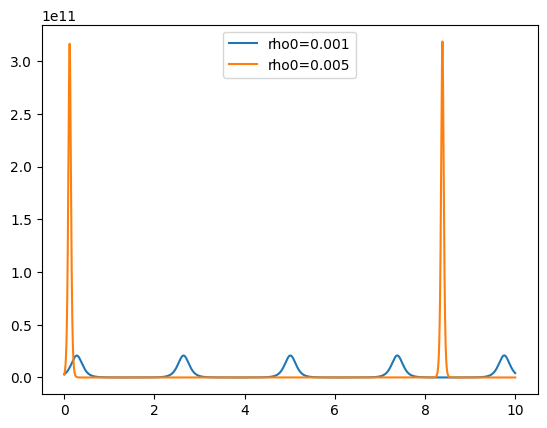

In [7]:
# Try both rhos and simulates them and plot them in the same plot.
for r in [0.001, 0.005]:
    P, T, rho, t = simulate_power_transient(r, 1.0e-4)
    plt.plot(t, P, label=f"rho0={r}")
plt.legend()
plt.show()

Since you have written code to simulate the transients, let us also look at what happens if we choose a different time step, and how it affects the numerical stability of the results. Simualte the case $\rho = 0.005$ for a few different time steps shorter than the neutron life time, and a few that are longer. 

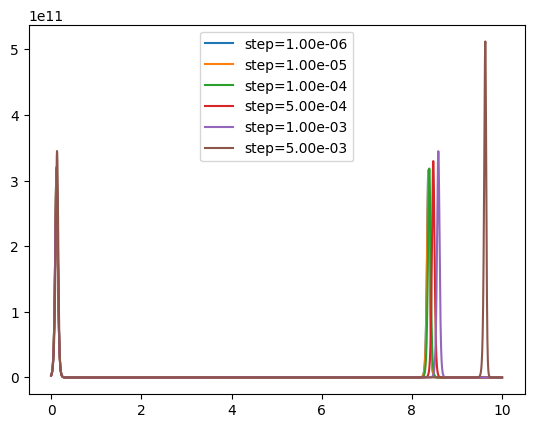

In [8]:
# I try several different timesteps with a differnece of x10 below 1e-4 and x5 and x2 above.
for step in [1.0e-6, 1.0e-5, 1.0e-4, 5.0e-4, 1.0e-3, 5.0e-3]:
    P, T, rho, t = simulate_power_transient(0.005, step)
    plt.plot(t, P, label=f"step={step:.2e}")
plt.legend()
plt.show()

If the delayed neutrons had been included, the peaks would obtain a tail that stretches out for a second or two. Note also that for time scales of a few seconds, the heat transfer from the fuel to the coolant would start to affect the results, which would lower fuel temperatures but raise moderator temperature. Eventually, the reactor would stabilize around a power level higher than the original 3000 MW, with a new, higher equilibrium fuel and coolant temperature that compensates for the reactivity insertion.

# conclusion
We can see that any time step below 1e-4 is very alike which suggests convergence at step = 1e-4. 1e-3 give a bit of a difference and 5e-3 gives a large difference. We can also see that the second peak is later and later with larger time steps, and that we get higher amplitudes for the second peak.